In [1]:
# -----------------------------------
# 0. SETUP
# -----------------------------------
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [2]:
# -----------------------------------
# 1. LOAD DATA
# -----------------------------------

# 1) Load expression matrix (log(TPM+1))
PARQUET = "./data/archs4/processed_short_proteins/train_expr_logtpm_short.parquet"
expr_df = pd.read_parquet(PARQUET)

print(expr_df.shape)  # [genes, samples]

# Transpose → AE expects rows = samples
X = expr_df.T.astype(np.float32).values   # shape: [n_samples, n_genes]

n_samples, n_genes = X.shape
print("Samples:", n_samples, "Genes:", n_genes)

# 2) Load gene order
gene_order = pd.read_csv(
    "./data/archs4/processed_short_proteins/train_gene_order_short.csv"
)["gene_symbol"].tolist()

# 3) Load validation data
VAL_PARQUET = "./data/archs4/processed_short_proteins/val_expr_logtpm_short.parquet"
val_expr_df = pd.read_parquet(VAL_PARQUET)
X_val = val_expr_df.T.astype(np.float32).values
print(f"\nValidation set shape: {X_val.shape}")


(19357, 76286)
Samples: 76286 Genes: 19357
Samples: 76286 Genes: 19357

Validation set shape: (9557, 19357)

Validation set shape: (9557, 19357)


In [3]:
# -----------------------------------
# 2. DATASET & DATALOADER
# -----------------------------------

class ExpressionDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

dataset = ExpressionDataset(X)
loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

val_dataset = ExpressionDataset(X_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=False)

print("Ready with", len(dataset), "training samples")
print("Ready with", len(val_dataset), "validation samples")


Ready with 76286 training samples
Ready with 9557 validation samples


In [4]:
import torch
import torch.nn as nn

class BulkAE(nn.Module):
    def __init__(self, n_genes, latent_dim=320):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(n_genes, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, n_genes),
        )

    def forward(self, x):
        z = self.encoder(x)      # latent space
        x_hat = self.decoder(z)  # reconstruction
        return x_hat, z


In [5]:
# -----------------------------------
# 4. INIT MODEL
# -----------------------------------

import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

device = "cuda"

model = BulkAE(n_genes, latent_dim=320).to(device)

# Distributed Data Parallel
if torch.cuda.device_count() > 1:
    dist.init_process_group(backend="nccl", init_method="env://")
    model = DDP(model, device_ids=[torch.cuda.current_device()])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
loss_history = []
val_loss_history = []
latent_history = []  # Store latent embeddings every N epochs
save_every_n_epochs = 5  # Save latent space every 5 epochs


EPOCHS = 20

for epoch in range(EPOCHS):
    # ===== TRAINING =====
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)

        x_hat, z = model(batch)
        loss = criterion(x_hat, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)

    # ===== VALIDATION =====
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_batch in val_loader:
            val_batch = val_batch.to(device)
            x_hat_val, _ = model(val_batch)
            val_loss = criterion(x_hat_val, val_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    # # ===== SAVE LATENT SPACE EVERY N EPOCHS =====
    # if epoch % save_every_n_epochs == 0:
    #     with torch.no_grad():
    #         X_tensor = torch.from_numpy(X).to(device)
    #         _, Z_epoch = model(X_tensor)
    #         Z_epoch = Z_epoch.cpu().numpy()
    #     latent_history.append({
    #         'epoch': epoch,
    #         'latent': Z_epoch,
    #         'train_loss': avg_loss,
    #         'val_loss': avg_val_loss
    #     })
    #     print(f"Epoch {epoch}: Saved latent space snapshot")

    # print(f"Epoch {epoch}: train_loss={avg_loss:.5f} | val_loss={avg_val_loss:.5f}")

print(f"\nCollected {len(latent_history)} latent space snapshots")


ValueError: Error initializing torch.distributed using env:// rendezvous: environment variable RANK expected, but not set

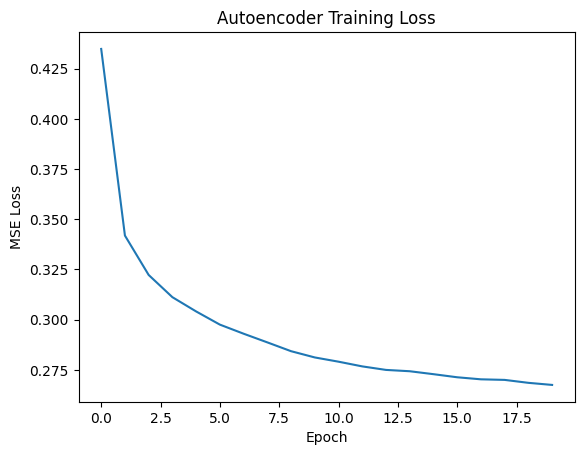

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Training Loss", linewidth=2)
plt.plot(val_loss_history, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.title("Autoencoder Training & Validation Loss", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

# Compute PCA for all latent snapshots
pca_snapshots = []
for snapshot in latent_history:
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(snapshot['latent'])
    pca_snapshots.append({
        'epoch': snapshot['epoch'],
        'coords': coords,
        'train_loss': snapshot['train_loss'],
        'val_loss': snapshot['val_loss']
    })

# Create animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

scatter = ax1.scatter([], [], s=3, alpha=0.6)
ax1.set_xlim(pca_snapshots[0]['coords'][:, 0].min() - 1, pca_snapshots[0]['coords'][:, 0].max() + 1)
ax1.set_ylim(pca_snapshots[0]['coords'][:, 1].min() - 1, pca_snapshots[0]['coords'][:, 1].max() + 1)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_title("Latent Space (PCA)")

# Loss plot
ax2.plot(loss_history, label="Train Loss", linewidth=2, alpha=0.7)
ax2.plot(val_loss_history, label="Val Loss", linewidth=2, alpha=0.7)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MSE Loss")
ax2.set_title("Training Progress")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Current epoch marker
current_epoch_line = ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label="Current")

title = fig.suptitle("", fontsize=14, fontweight='bold')

def animate(frame):
    snapshot = pca_snapshots[frame]
    coords = snapshot['coords']
    epoch = snapshot['epoch']
    
    scatter.set_offsets(coords)
    current_epoch_line.set_xdata([epoch, epoch])
    title.set_text(f"Epoch {epoch} | Train Loss: {snapshot['train_loss']:.5f} | Val Loss: {snapshot['val_loss']:.5f}")
    
    return scatter, current_epoch_line, title

anim = FuncAnimation(fig, animate, frames=len(pca_snapshots), interval=500, blit=True, repeat=True)
plt.tight_layout()
plt.show()

print(f"Animation complete! {len(pca_snapshots)} frames")


In [ ]:
# -----------------------------------
# 7. SAVE MODEL
# -----------------------------------
SAVE_DIR = "./data/autoencoder"
os.makedirs(SAVE_DIR, exist_ok=True)

# Extract module from DDP wrapper
model_to_save = model.module if isinstance(model, DDP) else model
torch.save(model_to_save.state_dict(), f"{SAVE_DIR}/bulk_ae.pt")
print("Saved model.")

# Compute latent for all samples
model.eval()
with torch.no_grad():
    X_tensor = torch.from_numpy(X).to(device)
    _, Z_sample_all = model(X_tensor)

Z_sample_all = Z_sample_all.cpu().numpy()

np.save(f"{SAVE_DIR}/z_sample_val.npy", Z_sample_all)
print("Saved z_sample latent:", Z_sample_all.shape)


Saved model.
Saved z_sample latent: (76286, 320)
Saved z_sample latent: (76286, 320)


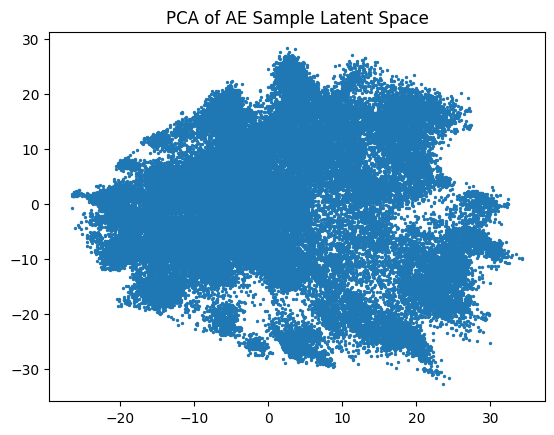

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
coords = pca.fit_transform(Z_sample_all)

plt.scatter(coords[:,0], coords[:,1], s=2)
plt.title("PCA of AE Sample Latent Space")
plt.show()


In [23]:
import pandas as pd

meta = pd.read_csv("./data/archs4/processed_short_proteins/val_metadata_short.csv")
print(meta.columns)


Index(['geo_accession', 'characteristics_ch1', 'source_name_ch1', 'text',
       'tcga_label'],
      dtype='object')


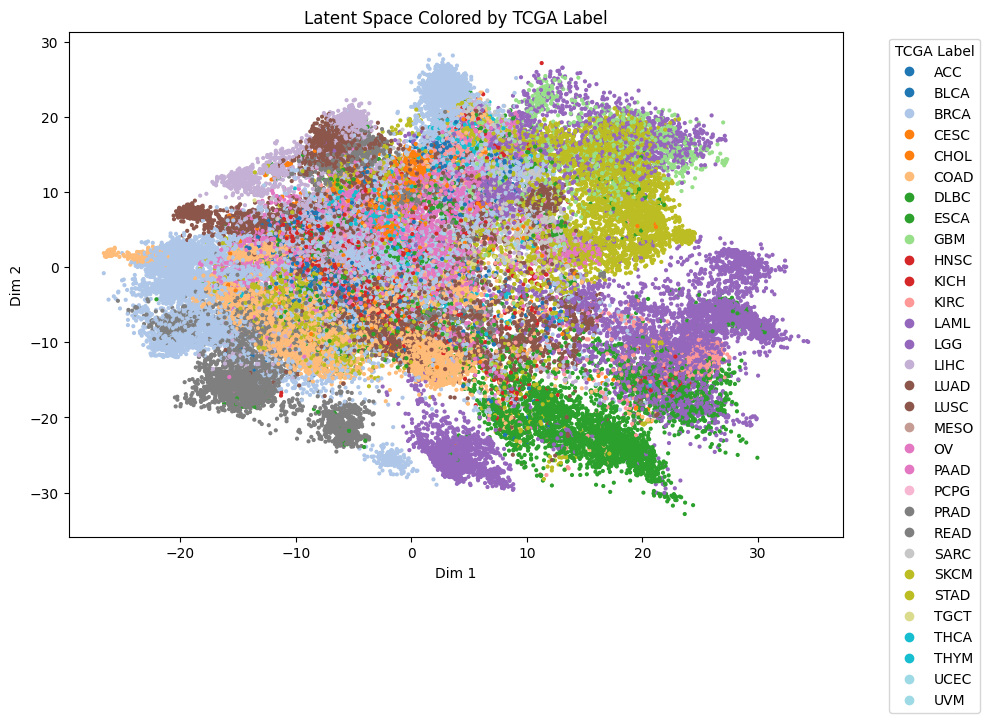

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Map each label to an integer color code
label_cats = meta["tcga_label"].astype("category")
colors = label_cats.cat.codes.values
labels = label_cats.cat.categories     # unique labels in correct order

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    coords[:, 0],
    coords[:, 1],
    c=colors,
    cmap="tab20",
    s=4
)

plt.title("Latent Space Colored by TCGA Label")
plt.xlabel("UMAP-1" if 'umap' in locals() else "Dim 1")
plt.ylabel("UMAP-2" if 'umap' in locals() else "Dim 2")

# Create a legend manually
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=6,
        label=label,
        color=plt.cm.tab20(i / max(1, len(labels)-1))
    )
    for i, label in enumerate(labels)
]

plt.legend(
    handles=handles,
    title="TCGA Label",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()
